# Analyzing VXUS & AVUV and predicting retirement amount 

In [2]:
# Important Links 

# Documentations
#   https://www.alphavantage.co/documentation/
#   https://pypi.org/project/yfinance/
#   https://github.com/ranaroussi/yfinance
#   https://pyfpdf.readthedocs.io/en/latest/
# ETF
#   https://etfdb.com/
# Tax & Investing
#   https://smartasset.com/investing/california-capital-gains-tax
#   https://www.investopedia.com/terms/c/compoundinterest.asp#:~:text=The%20compound%20interest%20formula%20is,is%20the%20number%20of%20periods.
#   https://www.calculatorsoup.com/calculators/financial/compound-interest-calculator.php

In [116]:
import yfinance as yf
import time
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

#### Turning CSV's into 2 dataframes, 1 for ETF info 1 for ETF stock weights

In [5]:
tickersList = ['VXUS', 'AVUV']
weightDF = []
infoDF = []
path = '/Users/admin/Desktop/stock research/individual etf csv'

for ticker in tickersList:
    # first 8 rows of each csv to turn into an info df
    tickerInfo = pd.read_csv(f'{path}/{ticker}-holdings.csv', delimiter= ':', nrows= 8, header= None)
    
    # transposing or pivoting df
    tickerInfo = tickerInfo.T
    
    # cleaning the df
    tickerInfo.columns = tickerInfo.loc[0]
    tickerInfo = tickerInfo.iloc[1:]
    tickerInfo.reset_index(drop=True, inplace=True)
    tickerInfo = tickerInfo[['Inception Date', 'Total Assets Under Management (in thousands)', 'Expense Ratio', 'Tracks This Index']]
    
    # getting the name of the file / etf 
    name = os.path.basename(f'{ticker}-holdings.csv')
    name = name.split('-')[0]
    
    tickerInfo.loc[:, 'etf'] = name
    
    # moving the column so that etf is first
    tickerInfo = tickerInfo[['etf'] + [col for col in tickerInfo.columns if col != 'etf']]
    
    # getting rid of white space 
    tickerInfo = tickerInfo.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # finally appending all the df's into one
    infoDF.append(tickerInfo)
    
    
    
    # stocks weight df
    tickerWeight = pd.read_csv(f'{path}/{ticker}-holdings.csv', skiprows= 11)
    tickerWeight['etf'] = name
    tickerWeight = tickerWeight[['etf'] + [col for col in tickerWeight.columns if col != 'etf']]
    
    weightDF.append(tickerWeight)
    
infoDF = pd.concat(infoDF, ignore_index= True)
weightDF = pd.concat(weightDF, ignore_index= True)

In [6]:
weightDF
infoDF

,etf,Inception Date,Total Assets Under Management (in thousands),Expense Ratio,Tracks This Index
0,VXUS,2011-01-26,75430800,0.08%,FTSE Global All Cap x US
1,AVUV,2019-09-24,12556100,0.25%,n/a


#### Getting historical data of ETFs

In [7]:
historicalDF = []

for ticker in tickersList:    
    ticker = yf.Ticker(f'{ticker}')
    df = ticker.history(period= 'max')
    df.reset_index(inplace= True)
    df['etf'] = ticker
    df = df[['etf'] + [col for col in df.columns if col != 'etf']]
    df.drop(['Open', 'High', 'Low', 'Stock Splits', 'Capital Gains', 'Volume'], axis = 1, inplace= True)
    historicalDF.append(df)
    
    
historicalDF = pd.concat(historicalDF, ignore_index= True)

In [8]:
# cleaning historical df
historicalDF['etf'] = historicalDF['etf'].astype('string')
historicalDF['etf'] = historicalDF['etf'].str.replace('yfinance.Ticker object <', '')
historicalDF['etf'] = historicalDF['etf'].str.replace('>', '')
historicalDF['Date'] = pd.to_datetime(historicalDF['Date'])

#### Getting all stocks from AVUV

In [9]:
avuvDF = weightDF.query(' etf == "AVUV" ')
avuvList = avuvDF['Symbol'].to_list()

In [10]:
avuvListFull = []

for symbol in avuvList:    
    symbol = yf.Ticker(f'{symbol}')
    df = symbol.history(period= 'max')
    df.reset_index(inplace= True)
    df['symbol'] = symbol
    df = df[['symbol'] + [col for col in df.columns if col != 'symbol']]
    avuvListFull.append(df)
    
    
avuvStocksDF = pd.concat(avuvListFull, ignore_index= True)
avuvStocksDF = avuvStocksDF[['symbol', 'Date', 'Close']]

$CRD.A: possibly delisted; No timezone found
$OTHER: possibly delisted; No timezone found
$OTHER: possibly delisted; No timezone found
$CRD.B: possibly delisted; No timezone found
/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_3884/3806254911.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avuvStocksDF = pd.concat(avuvListFull, ignore_index= True)


#### Finding YoY returns on AVUV, its stock holdings, and VXUS

In [11]:
historicalDF['Year'] = historicalDF['Date'].dt.year
df = historicalDF.groupby(['etf', 'Year'])['Date'].agg(min_date=('min'), max_date=('max')).reset_index()

min_df = df.merge(historicalDF, left_on=['etf', 'min_date'], right_on= ['etf', 'Date'])
max_df = df.merge(historicalDF, left_on=['etf', 'max_date'], right_on= ['etf', 'Date'])

min_df.rename(columns={'Close': 'min_close'}, inplace= True)
max_df.rename(columns={'Close': 'max_close'}, inplace= True)

min_df = min_df[['etf', 'Year_x', 'min_close']]
max_df = max_df[['etf', 'Year_x', 'max_close']]

df = min_df.merge(max_df, left_on= ['etf', 'Year_x'], right_on= ['etf', 'Year_x'])

# yoy return 
df['yoy'] = ((df['max_close'] - df['min_close']) / df['min_close']) * 100

# average return
avgYoY = df.groupby('etf')['yoy'].mean()
avgYoY = avgYoY.reset_index()
avgYoY = avgYoY.rename(columns={'yoy': 'avg'})

avgYoY

,etf,avg
0,AVUV,13.961846
1,VXUS,5.295238


In [12]:
avuvStocksDF['symbol'] = avuvStocksDF['symbol'].astype(str)
avuvStocksDF['symbol'] = avuvStocksDF['symbol'].str.replace('yfinance.Ticker object <', '')
avuvStocksDF['symbol'] = avuvStocksDF['symbol'].str.replace('>', '')

avuvStocksDF['Year'] = avuvStocksDF['Date'].dt.year
df = avuvStocksDF.groupby(['symbol', 'Year'])['Date'].agg(min_date=('min'), max_date=('max')).reset_index()

min_df = df.merge(avuvStocksDF, left_on=['symbol', 'min_date'], right_on= ['symbol', 'Date'])
max_df = df.merge(avuvStocksDF, left_on=['symbol', 'max_date'], right_on= ['symbol', 'Date'])

min_df.rename(columns={'Close': 'min_close'}, inplace= True)
max_df.rename(columns={'Close': 'max_close'}, inplace= True)

min_df = min_df[['symbol', 'Year_x', 'min_close']]
max_df = max_df[['symbol', 'Year_x', 'max_close']]

df = min_df.merge(max_df, left_on= ['symbol', 'Year_x'], right_on= ['symbol', 'Year_x'])

# yoy return 
df['yoy'] = ((df['max_close'] - df['min_close']) / df['min_close']) * 100
avg = df['yoy'].mean()

# 17.204950886917427

#### Finding industries within AVUV

In [23]:
symbolDF = []

for symbol in avuvList:    
    symbol = yf.Ticker(f'{symbol}')
    dict = symbol.info
    df = pd.DataFrame([dict])
    df['symbol'] = symbol
    symbolDF.append(df)
    
    # added a delay function because yfinance broke from high usage 
    time.sleep(1)
    
    
symbolDF = pd.concat(symbolDF, ignore_index= True)
symbolDF = symbolDF[['symbol', 'industry', 'sector']]
symbolDF.drop_duplicates(inplace= True)
symbolDF.dropna(inplace= True)

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OTHER?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OTHER&crumb=RW9kOtodQih
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/OTHER?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=OTHER&crumb=RW9kOtodQih
/var/folders/hk/jzskg0xs5pjggw047qcwrp980000gn/T/ipykernel_3884/4169285313.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  symbolDF = pd.concat(symbolDF, ignore_index= True)


In [24]:
symbolDF['symbol'] = symbolDF['symbol'].astype(str)
symbolDF['symbol'] = symbolDF['symbol'].str.replace('yfinance.Ticker object <', '')
symbolDF['symbol'] = symbolDF['symbol'].str.replace('>', '')

In [25]:
avuvWeight = weightDF.query(' etf == "AVUV" ')
df = avuvWeight.merge(symbolDF, left_on = 'Symbol', right_on = 'symbol')
df = df[['etf', 'symbol', 'industry', 'Weighting']]
df['Weighting'] = df['Weighting'].str.replace('%', '').astype(float)
df = df.groupby(by= 'industry')['Weighting'].sum()
df = df.reset_index()
df

,industry,Weighting
0,Advertising Agencies,0.01
1,Aerospace & Defense,0.17
2,Agricultural Inputs,0.03
3,Airlines,1.94
4,Aluminum,0.27
...,...,...
99,Thermal Coal,1.01
100,Tools & Accessories,0.35
101,Trucking,1.31
102,Utilities - Diversified,0.00


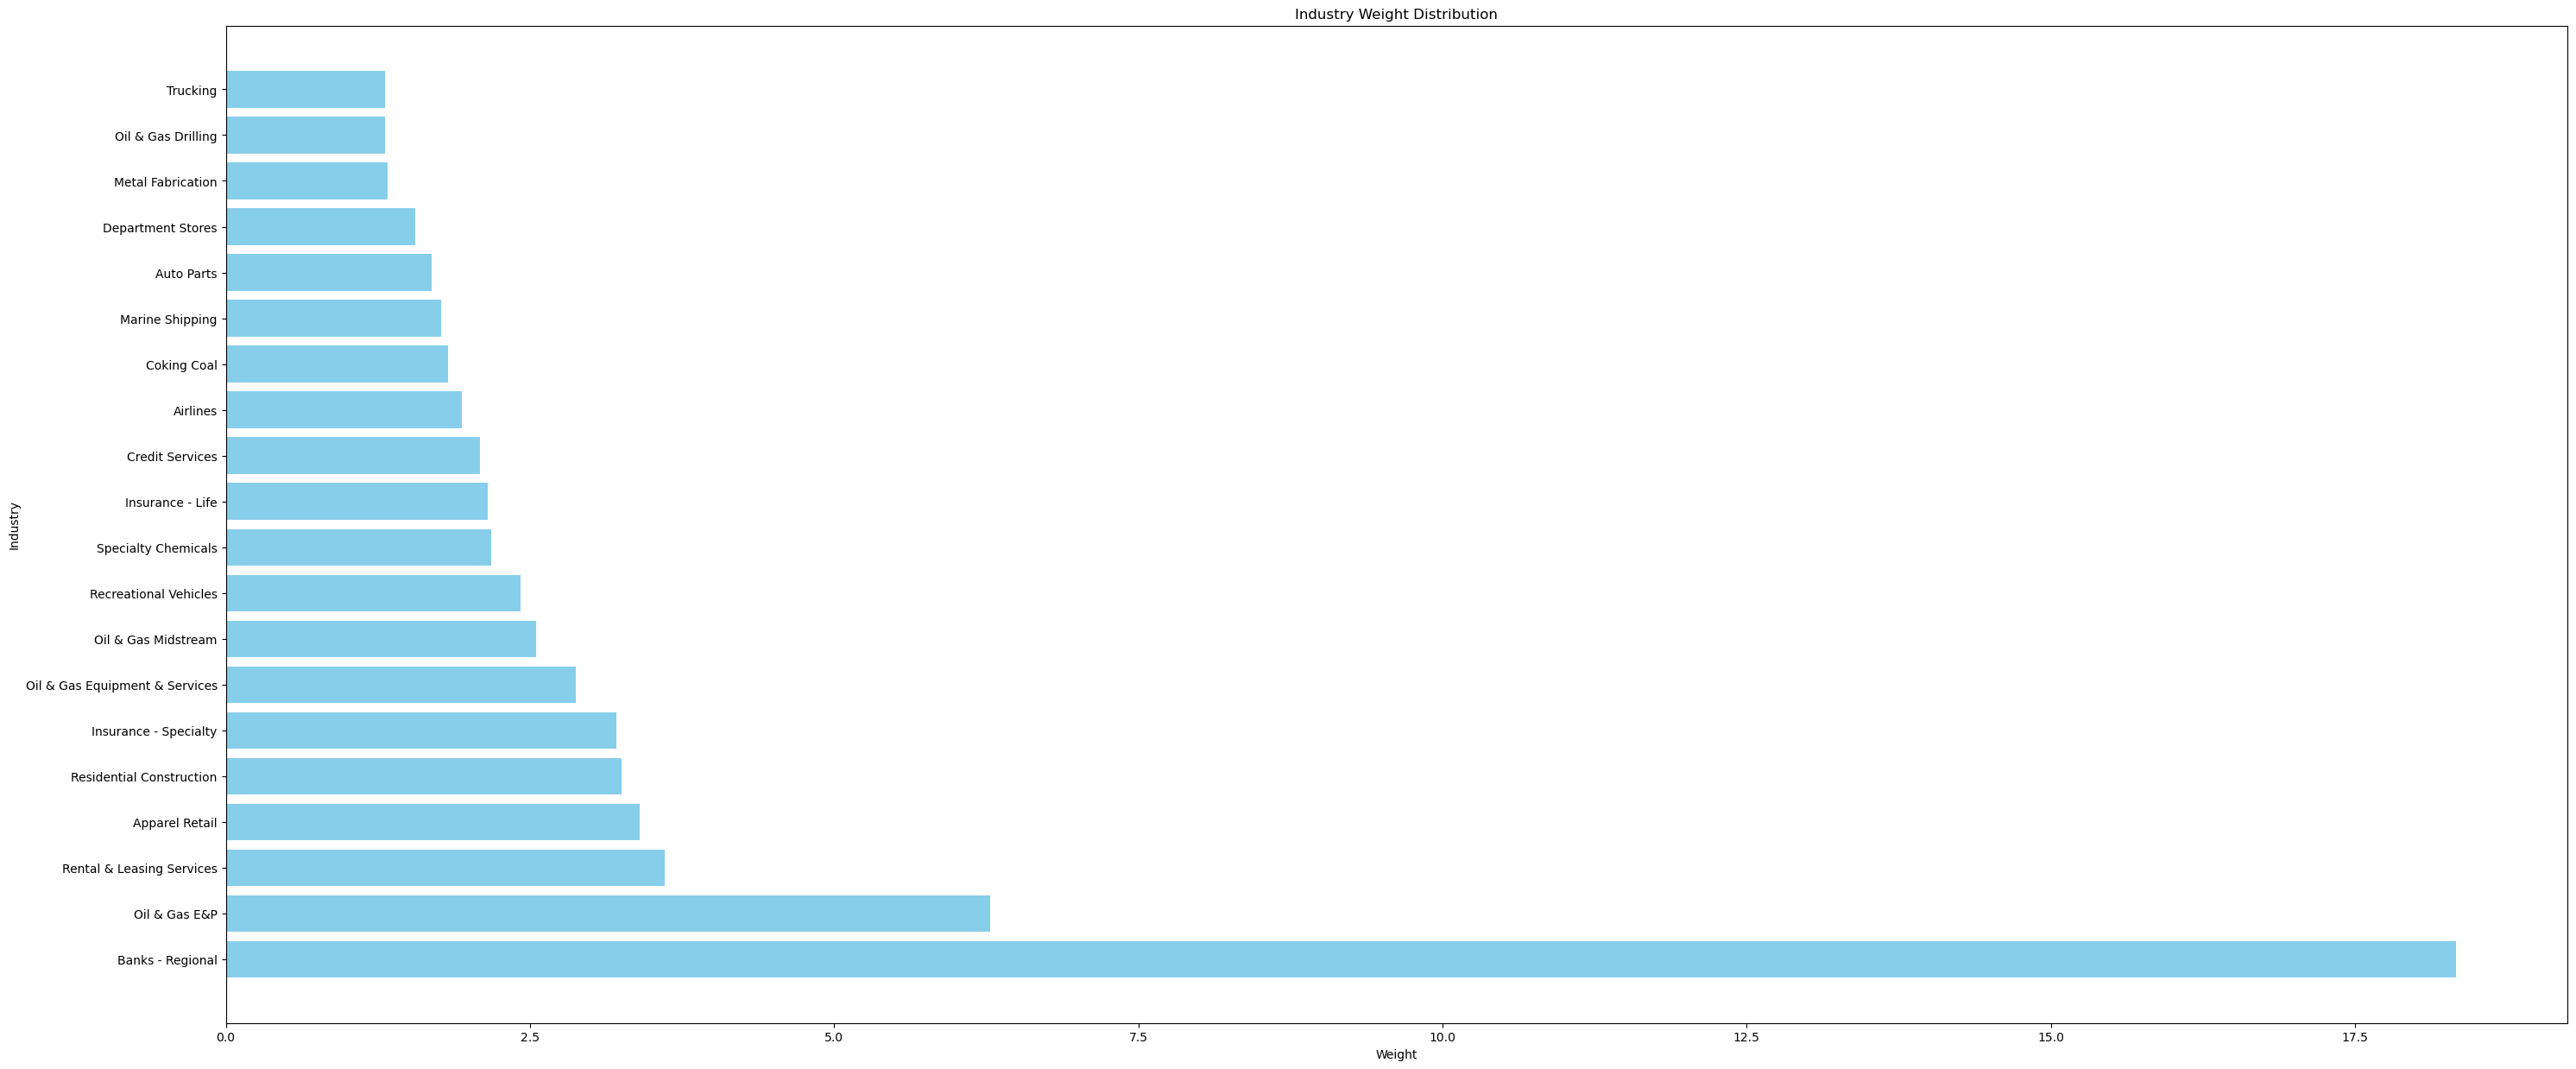

In [26]:
top_20_df = df.sort_values(by='Weighting', ascending=False).head(20)

plt.figure(figsize=(35, 15)) 

plt.barh(top_20_df['industry'], top_20_df['Weighting'], color='skyblue')  

plt.xlabel('Weight')  
plt.ylabel('Industry')  
plt.title('Industry Weight Distribution') 

plt.show() 

#### Calculating investments over n years

#### Creating bar graph to show growth 

In [81]:
listInitial = []
listMonthly = []
listYear = []


for year in range(1,40): # range is 1 - 39 because I have 39 years until I hit retirement age
    returnsPath = '/Users/admin/Desktop/stock research/final output csvs/etf_avg_returns.csv'
    returns = pd.read_csv(f'{returnsPath}')
    returnsDF = pd.concat([returns, avgYoY])

    etfs = ['VOO', 'AVUV', 'VXUS']
    returnsDF.query(' etf in @etfs', inplace= True)

    returnVOO = returnsDF.query('etf == "VOO"')['avg'].iloc[0]
    returnAVUV = returnsDF.query('etf == "AVUV"')['avg'].iloc[0]
    returnVXUS = returnsDF.query('etf == "VXUS"')['avg'].iloc[0]


    # allocation percentage as a whole number of each ETF I'll be investing in
    vooAllocation = 0.5
    avuvAllocation = 0.3
    vxusAllocation = 0.2

    # initial investment based on the allocation 
    initialInvestment = 2000
    initialVOO = initialInvestment * vooAllocation
    initialAVUV = initialInvestment * avuvAllocation
    initialVXUS = initialInvestment * vxusAllocation

    # monthly contributions based on the allocation
    monthlyContribution = 200
    monthlyVOO = monthlyContribution * vooAllocation
    monthlyAVUV = monthlyContribution * avuvAllocation
    monthlyVXUS = monthlyContribution * vxusAllocation

    # converting annual returns of etfs to monthly returns
    returnVOO_monthly = (1 + returnVOO / 100) ** (1 / 12) - 1
    returnAVUV_monthly = (1 + returnAVUV / 100) ** (1 / 12) - 1
    returnVXUS_monthly = (1 + returnVXUS / 100) ** (1 / 12) - 1

    # number of months (39 years until I hit retirement age of 65)
    months = year * 12

    # future value of initial investments
    pVOO = initialVOO * (1 + returnVOO_monthly) ** months
    pAVUV = initialAVUV * (1 + returnAVUV_monthly) ** months
    pVXUS = initialVXUS * (1 + returnVXUS_monthly) ** months

    # total value of initial investments
    totalInitial = pVOO + pAVUV + pVXUS

    # future value of monthly contributions
    mVOO = monthlyVOO * (((1 + returnVOO_monthly) ** months - 1) / returnVOO_monthly) * (1 + returnVOO_monthly)
    mAVUV = monthlyAVUV * (((1 + returnAVUV_monthly) ** months - 1) / returnAVUV_monthly) * (1 + returnAVUV_monthly)
    mVXUS = monthlyVXUS * (((1 + returnVXUS_monthly) ** months - 1) / returnVXUS_monthly) * (1 + returnVXUS_monthly)

    # total value of monthly contributions
    totalMonth = mVOO + mAVUV + mVXUS

    # adding up the initial investment and contributions
    total = pVOO + pAVUV + pVXUS + mVOO + mAVUV + mVXUS
    total = "${:,.2f}".format(total)


    listInitial.append(totalInitial)
    listMonthly.append(totalMonth)
    listYear.append(year)

    # creating a dataframe to plot
    df = pd.DataFrame(
        {'year': listYear,
        'initial': listInitial,
        'monthly': listMonthly
        }
    )


df = df.round(2)
df['total'] = df['initial'] + df['monthly']

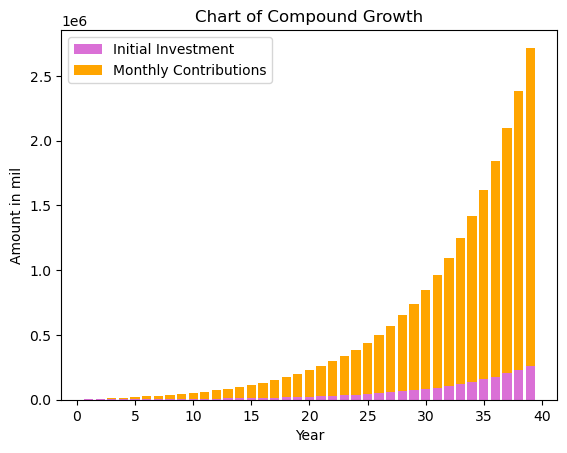

In [82]:
# visualizing the growth
initial = df['initial']
monthly = df['monthly']
year = df['year']

# stacked bar graph to show how both the initial investment and monthly contributions grow over time
plt.bar(year, initial, color = 'orchid', label = 'Initial Investment')
plt.bar(year, monthly, bottom = initial, color = 'orange', label = 'Monthly Contributions')

plt.xlabel('Year')
plt.ylabel('Amount in mil')
plt.title('Chart of Compound Growth')
plt.legend()

plt.show()

In [83]:
# before and after capital gains taxes in California visualization
finalTotal = df['total'].iloc[-1] 

# federal capital gains tax for long term holds (defined as holding for over 1 year)
if finalTotal > 518900:
    fedtaxLimit = 47025
    LTtaxRate = .15
    fedtaxNum = (finalTotal - fedtaxLimit) * LTtaxRate

# progressive state (CA) capital gains tax structure
if finalTotal > 1000000:
    bracket1 = 10412 * .01 
    bracket2 = (24684 - 10412) * .02
    bracket3 = (38959 - 24684) * .04
    bracket4 = (54081 - 38959) * .06
    bracket5 = (68350 - 54081) * .08
    bracket6 = (349137 - 68350) * .093
    bracket7 = (418961 - 349137) * .1030
    bracket8 = (698271 - 418961) * .1130
    bracket9 = (1000000 - 698271) * .1230
    bracket10 = (finalTotal - 1000000) * .1330
    
    statetaxNum = bracket1 + bracket2 + bracket3 + bracket4 + bracket5 + bracket6 + bracket7 + bracket8 + bracket9 + bracket10


totalTax = fedtaxNum + statetaxNum
net = finalTotal - totalTax

400674.01349999994 333507.77697


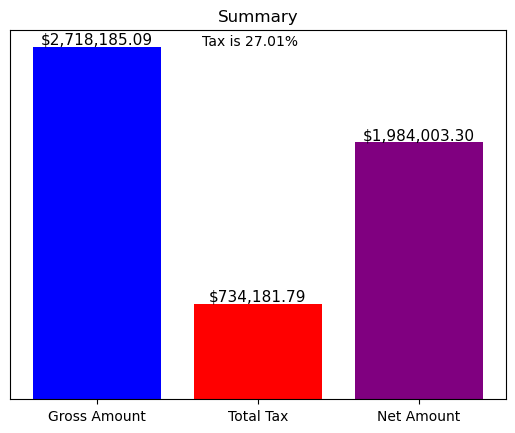

In [114]:
# visualizing the taxes
labels = ['Gross Amount', 'Total Tax', 'Net Amount']
values = [finalTotal, totalTax, net]
bars = plt.bar(labels, values, color=['blue', 'red', 'purple'])
taxPercentage = round((totalTax / finalTotal) * 100, 2)

for bar in bars:
    # getting the height of each bar
    height = bar.get_height() 
    # adding labels, placing label above each bar, aligning them, and rounding to 2 decimals
    plt.text(bar.get_x() + bar.get_width()/2, height, f'${height:,.2f}',ha = 'center', va = 'bottom', fontsize = 11, color = 'black')


plt.title('Summary')
plt.suptitle(f'Tax is {taxPercentage}%', fontsize = 10, y = 0.87)

# removing y axis ticks and label
plt.yticks([])

plt.show()